In this lab, you should try to implement some of the techniques discussed in the lecture.
Here is a list of reasonable tasks.
 
Easy:
 * L1 or L2 regularization (choose one)
 * momentum, Nesterov's momentum (choose one)

Medium difficulty:
 * Adagrad, RMSProp (choose one)
 * dropout
 * data augmentation (tiny rotatations, up/down-scalings etc.)

Try to test your network to see if these changes improve accuracy. They improve accuracy much more if you increase the layer size, and if you add more layers.

In [35]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

--2019-03-22 08:47:22--  https://s3.amazonaws.com/img-datasets/mnist.npz
Translacja s3.amazonaws.com (s3.amazonaws.com)... 52.217.0.150
Łączenie się z s3.amazonaws.com (s3.amazonaws.com)|52.217.0.150|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 11490434 (11M) [application/octet-stream]
Zapis do: `mnist.npz'

mnist.npz           100%[===================>]  10,96M   149KB/s    w 78s      

2019-03-22 08:48:42 (143 KB/s) - zapisano `mnist.npz' [11490434/11490434]



In [30]:
# Let's read the mnist dataset

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']
        
    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.
    
    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1
    
    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

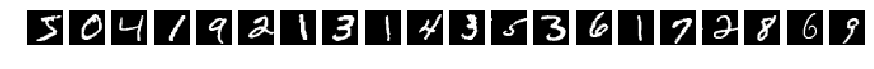

In [48]:
def shift_example(digit):
    return np.roll(digit.reshape(28, 28), 3, axis=1)

num_samples = 20
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    ex = shift_example(x_train[i])
    s.imshow(ex, cmap='gray')
    s.axis('off')

In [26]:
def shift_example_left(digit):
    return digit

def shift_example_right(digit):
    return digit

def rotate_example_random(digit, max_rot_deg=10):
    return digit

def augment_example(digit):
    return [digit, shift_example(digit)]

zipped = map(lambda x: (augment_example(x[0]), x[1]), zip(x_train, y_train))
flatten = [(x, y) for li, y in zipped for x in li]

xs, ys = ([ a for a,b in flatten ], [ b for a,b in flatten ])
x_train, y_train = np.array(xs), np.array(ys)

(60000, 784)
(10000, 10)


In [27]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

In [28]:
class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.momentum_w = [np.zeros((y, x)) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.momentum_b = [np.zeros((y, 1)) for y in sizes[1:]]

    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a
    
    def update_mini_batch(self, mini_batch, eta, l2_reg=0.001, lamb=0.):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate      
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T) # CHANGE: Just one call!
        self.momentum_w = [m_w * lamb - (eta/len(mini_batch[0]))*nw 
                           for m_w, nw in zip(self.momentum_w, nabla_w)]
        self.momentum_b = [m_b * lamb - (eta/len(mini_batch[0]))*nb 
                   for m_b, nb in zip(self.momentum_b, nabla_b)]
            
        self.weights = [w * (1 - eta * l2_reg / len(mini_batch[0])) + m_w
                        for w, m_w in zip(self.weights, self.momentum_w)]
        self.biases = [b + m_b 
                       for b, m_b in zip(self.biases, self.momentum_b)]
        
    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)
        
        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])] # automatic here
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)] # CHANGE: Need to sum here
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y) 
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                print("Epoch: {0}, Accuracy: {1}".format(j, self.evaluate((x_test, y_test))))
            else:
                print("Epoch: {0}".format(j))


network = Network([784,30,10])
network.SGD((x_train, y_train), epochs=300, mini_batch_size=100, eta=3., test_data=(x_test, y_test))



Epoch: 0, Accuracy: 0.8113
Epoch: 1, Accuracy: 0.8632
Epoch: 2, Accuracy: 0.8857
Epoch: 3, Accuracy: 0.8978
Epoch: 4, Accuracy: 0.9063


KeyboardInterrupt: 